In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab \Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

print(device)

cuda


# Data preparation

In [ ]:
DATASET = 'MELD'    # @param ['MELD', 'MaSaC']
MAX_LENGTH = 128    # @param [96, 128, 256] {type: 'raw'}
BATCH_SIZE = 32    # @param [8, 16, 32] {type: 'raw'}

In [ ]:
if DATASET == 'MELD':
    DESIGNATED_MODEL = 'bert-base-cased'
elif DATASET == 'MaSaC':
    DESIGNATED_MODEL = 'bert-base-multilingual-cased'

In [ ]:
def get_data(dataset_name, stage):
    def to_float(x):
        try:
            return float(x)
        except ValueError:
            return 1

    df = pd.read_json(f'data/EDiReF_{stage}_data/{dataset_name}_{stage}_efr.json')
    df["triggers"] = df["triggers"].apply(lambda lst: [np.nan if x is None else x for x in lst])
    df = df[df["triggers"].apply(lambda lst: not any(pd.isna(x) for x in lst))]
    df["triggers"] = df["triggers"].apply(lambda lst: [to_float(x) for x in lst])

    conversations = list(df['utterances'])
    emotions = list(df['emotions'])
    triggers = list(df['triggers'])

    return conversations, emotions, triggers

In [ ]:
train_conversations, train_emotions, train_triggers = get_data(DATASET, 'train')
val_conversations, val_emotions, val_triggers = get_data(DATASET, 'val')

In [ ]:
conversations = train_conversations + val_conversations
emotions = train_emotions + val_emotions
triggers = train_triggers + val_triggers

In [ ]:
flattened_emotions = [sent for conv in emotions for sent in conv]
unique_emotions = set(flattened_emotions)

labels_to_ids = {k: v for v, k in enumerate(unique_emotions)}
ids_to_labels = {v: k for v, k in enumerate(unique_emotions)}
emotions = [[labels_to_ids[emotion] for emotion in conv] for conv in emotions]

In [ ]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y1, y2, val_size = 0.2, test_size = 0.2, random_state = None):
    X_train_val, X_test, y1_train_val, y1_test, y2_train_val, y2_test = train_test_split(
        X, y1, y2, test_size=test_size, random_state=random_state
    )

    val_relative_size = val_size / (1 - test_size)

    X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(
        X_train_val, y1_train_val, y2_train_val, test_size=val_relative_size, random_state=random_state
    )

    return (X_train, X_val, X_test, y1_train, y1_val, y1_test, y2_train, y2_val, y2_test)

In [ ]:
X_train, X_val, X_test, y1_train, y1_val, y1_test, y2_train, y2_val, y2_test = train_val_test_split(
    conversations, emotions, triggers, test_size=0.15, val_size=0.15, random_state=2024
    )

In [ ]:
tokenizer = BertTokenizer.from_pretrained(DESIGNATED_MODEL)

In [ ]:
def tokenize_conversation(conversations, max_length = 128):
    input_ids = []
    attention_masks = []

    for conversation in conversations:
        dialogue = " [SEP] ".join(conversation)
        encoded = tokenizer(
            dialogue,
            truncation = True,
            padding = 'max_length',
            max_length = max_length,
            return_tensors = "pt"
        )
        input_ids.append(encoded["input_ids"].squeeze(0))
        attention_masks.append(encoded["attention_mask"].squeeze(0))

    return input_ids, attention_masks

In [ ]:
def pad_labels(labels, max_length = 128):
    padded_labels = []
    for label_set in labels:
        label_tensor = torch.tensor(label_set, dtype = torch.float)
        # Pad with -1 to ignore padding tokens in the loss function
        padded_tensor = torch.cat(
            [label_tensor, torch.full((max_length - len(label_set),), -1)]
        )
        padded_labels.append(padded_tensor)
    return padded_labels

In [ ]:
class ConversationDataset(Dataset):
    def __init__(self, input_ids, attention_masks, emotion_labels, trigger_labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.emotion_labels = emotion_labels
        self.trigger_labels = trigger_labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "emotion_labels": self.emotion_labels[idx],
            "trigger_labels": self.trigger_labels[idx],
        }

In [ ]:
def create_dataloader(conversations, emotions, triggers, max_length = 128):
    input_ids, attention_masks = tokenize_conversation(conversations, max_length = max_length)
    emotion_labels = pad_labels(emotions, max_length = max_length)
    trigger_labels = pad_labels(triggers, max_length = max_length)

    dataset = ConversationDataset(input_ids, attention_masks, emotion_labels, trigger_labels)
    loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = False)

    return loader

In [ ]:
train_loader = create_dataloader(X_train, y1_train, y2_train, max_length = MAX_LENGTH)
val_loader = create_dataloader(X_val, y1_val, y2_val, max_length = MAX_LENGTH)
test_loader = create_dataloader(X_test, y1_test, y2_test, max_length = MAX_LENGTH)

# Model configuration

In [ ]:
class EDiReFReferenceModel(nn.Module):
    def __init__(self, num_classes, model_name = 'bert-base-uncased', train_bert = True, hidden_size = 256):
        super(EDiReFReferenceModel, self).__init__()

        self.model = BertModel.from_pretrained(model_name)
        for param in self.model.parameters():
            param.requires_grad = train_bert  # True to fine-tune model

        self.fc = nn.Linear(self.model.config.hidden_size, hidden_size)

        self.emotion_classifier = nn.Linear(hidden_size, num_classes)
        self.trigger_classifier = nn.Linear(hidden_size, 1)

        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, input_ids, attention_mask):
        model_outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        embeddings = model_outputs.last_hidden_state
        pooled_embeddings = self.dropout(embeddings)

        fc_output = torch.relu(self.fc(pooled_embeddings))

        emotion_logits = self.emotion_classifier(fc_output)
        trigger_logits = self.trigger_classifier(fc_output).squeeze(-1)

        return emotion_logits, trigger_logits

# Training parameters

In [ ]:
TRAIN_BERT = True   # @param {type: 'boolean'}
LEARNING_RATE = 0.00002  # @param {type: 'slider', min: 1E-5, max: 5E-5, step: 1E-5}
NUM_EPOCHS = 5  # @param {type: 'slider', min: 3, max: 15, step: 1}
WEIGHT_TRIGGERS = False # @param {type: 'boolean'}

In [ ]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

moe = EDiReFReferenceModel(num_classes = len(labels_to_ids), model_name = DESIGNATED_MODEL, train_bert = TRAIN_BERT, hidden_size = 128)
optimizer = AdamW(moe.parameters(), lr = LEARNING_RATE)

pos_weight = None
if WEIGHT_TRIGGERS and DATASET == 'MaSaC':
    flattened_triggers = [x for y in y2_train for x in y]
    num_negative_samples = len([x for x in flattened_triggers if x == 0])*0.8
    num_positive_samples = len(flattened_triggers) - num_negative_samples
    pos_weight_value = num_negative_samples / num_positive_samples
    pos_weight = torch.tensor([pos_weight_value], device = device)

emotion_loss_fn = CrossEntropyLoss()
trigger_loss_fn = BCEWithLogitsLoss(pos_weight = pos_weight)

In [ ]:
moe.to(device)

EDiReFReferenceModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
def remove_padding(logits, labels, task):
    mask = labels != -1

    logits_flat = logits.view(-1, logits.size(-1)) if task == 'emotion' else logits.view(-1)
    labels_flat = labels.view(-1)

    logits = logits_flat[mask.view(-1)]
    labels = labels_flat[mask.view(-1)]

    return logits, labels

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    val_loss, nb_steps = 0.0, 0
    total_emotion_preds, correct_emotion_preds = 0, 0
    total_trigger_preds, correct_trigger_preds = 0, 0
    val_logs = []

    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotion_labels = batch['emotion_labels'].to(device)
            trigger_labels = batch['trigger_labels'].to(device)

            emotion_logits, trigger_logits = model(input_ids, attention_mask)

            # removing padding
            emotion_logits, emotion_labels = remove_padding(emotion_logits, emotion_labels, 'emotion')
            trigger_logits, trigger_labels = remove_padding(trigger_logits, trigger_labels, 'trigger')

            # calculating loss
            emotion_loss = emotion_loss_fn(emotion_logits, emotion_labels.long())
            trigger_loss = trigger_loss_fn(trigger_logits, trigger_labels)

            loss = emotion_loss + trigger_loss
            val_loss += loss.item()

            # calculating accuracy
            emotion_preds = torch.argmax(emotion_logits, dim=-1)
            trigger_preds = (torch.sigmoid(trigger_logits).squeeze(-1) > 0.5).long()

            correct_emotion_preds += torch.sum(emotion_preds == emotion_labels).item()
            correct_trigger_preds += torch.sum(trigger_preds == trigger_labels).item()

            total_emotion_preds += emotion_labels.numel()
            total_trigger_preds += trigger_labels.numel()

            nb_steps += 1

            if idx % 100 == 0:
                loss_step = val_loss / nb_steps
                print(f'      Validation loss per 100 training steps: {loss_step}')
                val_logs.append(f'      Validation loss per 100 training steps: {loss_step}\n')

        avg_val_loss = val_loss / len(val_loader)
        emotion_accuracy = correct_emotion_preds / total_emotion_preds
        trigger_accuracy = correct_trigger_preds / total_trigger_preds
        avg_val_accuracy = (emotion_accuracy + trigger_accuracy)/2

    return avg_val_loss, avg_val_accuracy, val_logs

In [ ]:
def train_and_validate(model, train_loader, val_loader, num_epochs = 3):
    train_logs = []

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        train_logs.append(f"Epoch [{epoch + 1}/{num_epochs}]\n")
        model.train()
        train_loss, nb_steps = 0.0, 0
        total_emotion_preds, correct_emotion_preds = 0, 0
        total_trigger_preds, correct_trigger_preds = 0, 0

        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotion_labels = batch['emotion_labels'].to(device)
            trigger_labels = batch['trigger_labels'].to(device)

            emotion_logits, trigger_logits = model(input_ids, attention_mask)

            # removing padding
            emotion_logits, emotion_labels = remove_padding(emotion_logits, emotion_labels, 'emotion')
            trigger_logits, trigger_labels = remove_padding(trigger_logits, trigger_labels, 'trigger')

            # calculating loss
            emotion_loss = emotion_loss_fn(emotion_logits, emotion_labels.long())
            trigger_loss = trigger_loss_fn(trigger_logits, trigger_labels)

            loss = emotion_loss + trigger_loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            # calculating accuracy
            emotion_preds = torch.argmax(emotion_logits, dim=-1)
            trigger_preds = (torch.sigmoid(trigger_logits).squeeze(-1) > 0.5).long()

            correct_emotion_preds += torch.sum(emotion_preds == emotion_labels).item()
            correct_trigger_preds += torch.sum(trigger_preds == trigger_labels).item()

            total_emotion_preds += emotion_labels.numel()
            total_trigger_preds += trigger_labels.numel()
            nb_steps += 1

            if idx % 100 == 0:
                loss_step = train_loss / nb_steps
                print(f'      Training loss per 100 training steps: {loss_step}')
                train_logs.append(f'      Training loss per 100 training steps: {loss_step}\n')

        avg_train_loss = train_loss / len(train_loader)
        emotion_accuracy = correct_emotion_preds / total_emotion_preds
        trigger_accuracy = correct_trigger_preds / total_trigger_preds
        avg_train_accuracy = (emotion_accuracy + trigger_accuracy)/2

        val_loss, val_accuracy, val_logs = evaluate(model, val_loader)
        train_logs.extend(val_logs)

        print(f"   Training Loss: {avg_train_loss:.3f}, Training Accuracy: {avg_train_accuracy:.3f}")
        train_logs.append(f"   Training Loss: {avg_train_loss:.3f}, Training Accuracy: {avg_train_accuracy:.3f}\n")

        print(f"   Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}\n")
        train_logs.append(f"   Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}\n\n")

    return train_logs

In [ ]:
logs = train_and_validate(moe, train_loader, val_loader, num_epochs = NUM_EPOCHS)

Epoch [1/5]
      Training loss per 100 training steps: 2.5364668369293213
      Validation loss per 100 training steps: 1.8493051528930664
   Training Loss: 2.040, Training Accuracy: 0.638
   Validation Loss: 1.922, Validation Accuracy: 0.647

Epoch [2/5]
      Training loss per 100 training steps: 1.8216534852981567
      Validation loss per 100 training steps: 1.6453311443328857
   Training Loss: 1.823, Training Accuracy: 0.660
   Validation Loss: 1.695, Validation Accuracy: 0.685

Epoch [3/5]
      Training loss per 100 training steps: 1.551485300064087
      Validation loss per 100 training steps: 1.3807263374328613
   Training Loss: 1.549, Training Accuracy: 0.712
   Validation Loss: 1.412, Validation Accuracy: 0.741

Epoch [4/5]
      Training loss per 100 training steps: 1.2678433656692505
      Validation loss per 100 training steps: 1.0671517848968506
   Training Loss: 1.215, Training Accuracy: 0.781
   Validation Loss: 1.095, Validation Accuracy: 0.806

Epoch [5/5]
      Tra

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from collections import defaultdict

def get_metrics(model, data_loader, dev):
    model.eval()

    emotion_accuracy = 0.0
    emotion_precision = 0.0
    emotion_recall = 0.0
    emotion_f1 = 0.0
    emotion_cm = None

    unique_emotions_f1 = dict.fromkeys(labels_to_ids.keys(), 0.0)

    trigger_accuracy = 0.0
    trigger_precision = 0.0
    trigger_recall = 0.0
    trigger_f1 = 0.0
    trigger_cm = None

    nb_steps = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(dev)
        attention_mask = batch['attention_mask'].to(dev)
        emotion_labels = batch['emotion_labels'].to(dev)
        trigger_labels = batch['trigger_labels'].to(dev)

        with torch.no_grad():
            # Forward pass
            emotion_logits, trigger_logits = model(input_ids, attention_mask)

            # Compute predictions for emotions
            emotion_logits, emotion_labels = remove_padding(emotion_logits, emotion_labels, 'emotion')

            emotion_preds = torch.argmax(emotion_logits, dim = -1)

            emotion_preds_flat = emotion_preds.cpu().numpy()
            emotion_labels_flat = emotion_labels.cpu().numpy()

            # Compute predictions for triggers
            trigger_logits, trigger_labels = remove_padding(trigger_logits, trigger_labels, 'trigger')

            trigger_preds = (torch.sigmoid(trigger_logits).squeeze(-1) > 0.5).long()

            trigger_preds_flat = trigger_preds.cpu().numpy()
            trigger_labels_flat = trigger_labels.cpu().numpy()

            # Calculate metrics for emotion classification
            emotion_accuracy += accuracy_score(emotion_labels_flat, emotion_preds_flat)
            emotion_precision += precision_score(emotion_labels_flat, emotion_preds_flat, average='weighted', zero_division = 0)
            emotion_recall += recall_score(emotion_labels_flat, emotion_preds_flat, average='weighted', zero_division = 0)
            emotion_f1 += f1_score(emotion_labels_flat, emotion_preds_flat, average='weighted', zero_division = 0)

            for idx, score in enumerate(f1_score(emotion_labels_flat, emotion_preds_flat, average = None, zero_division = 0)):
                unique_emotions_f1[ids_to_labels[idx]] += score

            if emotion_cm is None:
                emotion_cm = confusion_matrix(emotion_labels_flat, emotion_preds_flat, labels = range(len(labels_to_ids)))
            else:
                emotion_cm += confusion_matrix(emotion_labels_flat, emotion_preds_flat, labels = range(len(labels_to_ids)))

            # Calculate metrics for trigger classification
            trigger_accuracy += accuracy_score(trigger_labels_flat, trigger_preds_flat)
            trigger_precision += precision_score(trigger_labels_flat, trigger_preds_flat, average='weighted', zero_division = 0)
            trigger_recall += recall_score(trigger_labels_flat, trigger_preds_flat, average='weighted', zero_division = 0)
            trigger_f1 += f1_score(trigger_labels_flat, trigger_preds_flat, average='weighted', zero_division = 0)

            if trigger_cm is None:
                trigger_cm = confusion_matrix(trigger_labels_flat, trigger_preds_flat, labels = [0, 1])
            else:
                trigger_cm += confusion_matrix(trigger_labels_flat, trigger_preds_flat, labels = [0, 1])

            nb_steps += 1

    metrics = defaultdict(lambda: {})

    # Calculate average metrics
    avg_emotion_accuracy = emotion_accuracy / nb_steps
    avg_emotion_precision = emotion_precision / nb_steps
    avg_emotion_recall = emotion_recall / nb_steps
    avg_emotion_f1 = emotion_f1 / nb_steps

    for key, value in unique_emotions_f1.items():
        unique_emotions_f1[key] = value / nb_steps

    metrics['emotion_classification'] = {'accuracy': avg_emotion_accuracy,
                                         'precision': avg_emotion_precision,
                                         'recall': avg_emotion_recall,
                                         'f1': {'avg': avg_emotion_f1}}
    metrics['emotion_classification']['f1'].update(unique_emotions_f1)

    avg_trigger_accuracy = trigger_accuracy / nb_steps
    avg_trigger_precision = trigger_precision / nb_steps
    avg_trigger_recall = trigger_recall / nb_steps
    avg_trigger_f1 = trigger_f1 / nb_steps

    metrics['trigger_classification'] = {'accuracy': avg_trigger_accuracy,
                                         'precision': avg_trigger_precision,
                                         'recall': avg_trigger_recall,
                                         'f1': avg_trigger_f1}

    return metrics, emotion_cm, trigger_cm

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels, title = "Confusion Matrix"):
    plt.figure(figsize = (10, 8))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Labels', fontsize = 14)
    plt.ylabel('True Labels', fontsize = 14)
    plt.title(title, fontsize = 16)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.tight_layout()
    plt.show()

In [ ]:
metrics, emotion_cm, trigger_cm = get_metrics(moe, test_loader, device)

# Output results
for task, results in metrics.items():
    print(f'Task: {task}')
    for metric, score in results.items():
        if metric != 'f1' or (metric == 'f1' and isinstance(score, (float, np.floating))):
            print(f'      {metric}: {score:.3f}')
        else:
            print(f'      f1: ')
            for x, y in score.items():
                print(f'          {x}: {y:.3f}')

Task: emotion_classification
      accuracy: 0.842
      precision: 0.846
      recall: 0.842
      f1: 
          avg: 0.835
          disgust: 0.431
          fear: 0.504
          neutral: 0.903
          joy: 0.876
          anger: 0.772
          sadness: 0.759
          surprise: 0.795
Task: trigger_classification
      accuracy: 0.835
      precision: 0.780
      recall: 0.835
      f1: 0.784


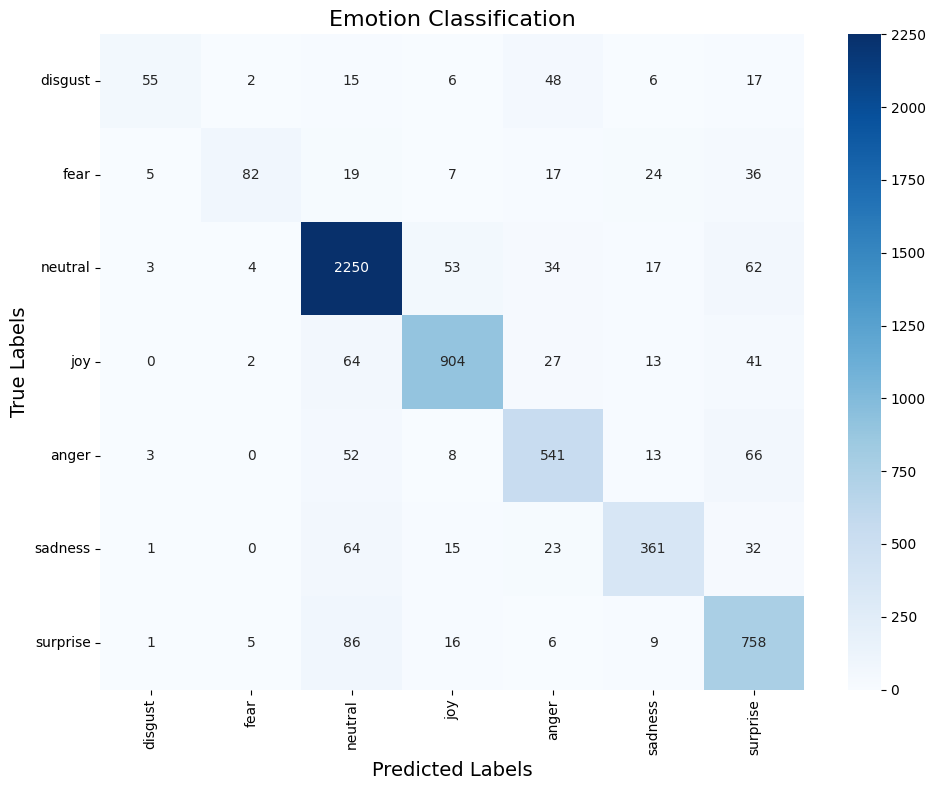

In [ ]:
plot_confusion_matrix(emotion_cm, [i for i in labels_to_ids.keys()], "Emotion Classification")

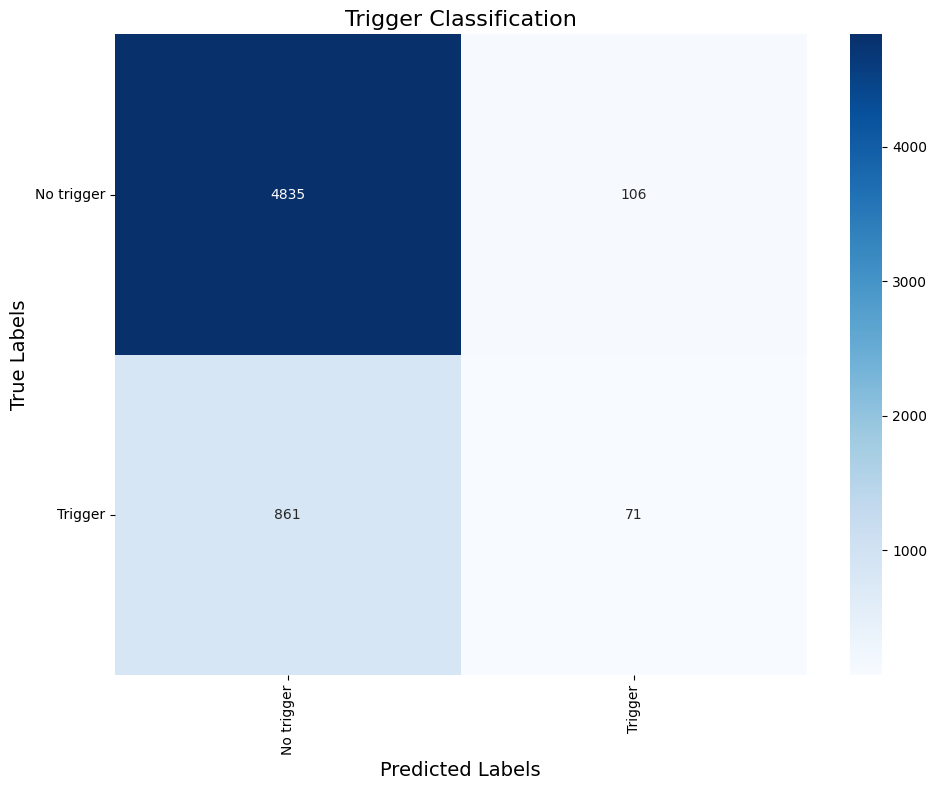

In [ ]:
plot_confusion_matrix(trigger_cm, ['No trigger', 'Trigger'], "Trigger Classification")

# Save experiment

In [ ]:
# torch.save(moe.state_dict(), f'trained_models/{DATASET}/moe_model_{GATE_TYPE}_dual_gate_{NUM_EXPERTS}_{EXPERT_TYPE}_experts_{TOP_K}_active_{LEARNING_RATE}_lr_{NUM_EPOCHS}_epochs.pth')

In [ ]:
def write_confusion_matrix(title, cm, labels):
    cm2txt = []
    col_width = max(len(max(labels, key=len)), 10)
    cm2txt.append('\n' + title + '\n')

    header = f"{'':<{col_width}}"
    header += "".join([f"{label:<{col_width}}" for label in labels])

    cm2txt.append(header + '\n')

    rows = []
    for i, label in enumerate(labels):
        row = f"{label:<{col_width}}"
        row += "".join([f"{value:<{col_width}}" for value in cm[i]])
        rows.append(row)

    cm2txt.append("\n".join(rows))

    return cm2txt

In [ ]:
if WEIGHT_TRIGGERS and DATASET in ['MaSaC', 'MaSaC_translated']:
    file_path = f'results/{DATASET}/weighted_reference_model_{TRAIN_BERT}_train_bert_{LEARNING_RATE}_lr_{NUM_EPOCHS}_epochs.txt'
else:
    file_path = f'results/{DATASET}/reference_model_{TRAIN_BERT}_train_bert_{LEARNING_RATE}_lr_{NUM_EPOCHS}_epochs.txt'

with open(file_path, 'w') as f:
    experiment_setup = [f'MAX_LENGTH = {MAX_LENGTH}\n',
                        f'BATCH_SIZE = {BATCH_SIZE}\n', '\n',
                        f'LEARNING_RATE = {LEARNING_RATE}\n',
                        f'NUM_EPOCHS = {NUM_EPOCHS}\n',
                        f'TRAIN_BERT = {TRAIN_BERT}\n',
                        f'WEIGHT_TRIGGERS = {WEIGHT_TRIGGERS}\n', '\n', '\n']

    experiment_results = []
    for task, results in metrics.items():
        experiment_results.append(f'\nTask: {task}\n')
        for metric, score in results.items():
            if metric != 'f1' or (metric == 'f1' and isinstance(score, (float, np.floating))):
                experiment_results.append(f'      {metric}: {score:.3f}\n')
            else:
                experiment_results.append(f'      f1:\n')
                for x, y in score.items():
                    experiment_results.append(f'          {x}: {y:.3f}\n')

    f.writelines(experiment_setup)
    f.writelines(logs)
    f.writelines(experiment_results)
    f.write("\n")
    writeable_emotion_cm = write_confusion_matrix('Emotion confusion matrix', emotion_cm, [i for i in labels_to_ids.keys()])
    f.writelines(writeable_emotion_cm)
    f.write("\n")
    writeable_trigger_cm = write_confusion_matrix('Trigger confusion matrix', trigger_cm, ['No trigger', 'Trigger'])
    f.writelines(writeable_trigger_cm)

# Load and test trained model

In [ ]:
# moe_loaded = MoEForEmotionAndTriggerClassification(num_experts = NUM_EXPERTS, k = TOP_K, num_classes = len(labels_to_ids), gate_type = GATE_TYPE, expert_type = EXPERT_TYPE)
# moe_loaded.load_state_dict(torch.load(f'trained_models/{DATASET}/moe_model_{GATE_TYPE}_dual_gate_{NUM_EXPERTS}_{EXPERT_TYPE}_experts_{TOP_K}_active_{LEARNING_RATE}_lr_{NUM_EPOCHS}_epochs.pth', map_location=torch.device('cpu')))

In [ ]:
# metrics, emotion_cm, trigger_cm = get_metrics(moe_loaded, test_loader, 'cpu')

# # Output results
# for task, results in metrics.items():
#     print(f'Task: {task}')
#     for metric, score in results.items():
#         if metric != 'f1' or (metric == 'f1' and isinstance(score, np.float64)):
#             print(f'      {metric}: {score:.3f}')
#         else:
#             print(f'      f1: ')
#             for x, y in score.items():
#                 print(f'          {x}: {y:.3f}')

In [ ]:
# plot_confusion_matrix(emotion_cm, [i for i in labels_to_ids.keys()], "Emotion Classification")

In [ ]:
# plot_confusion_matrix(trigger_cm, ['No trigger', 'Trigger'], "Trigger Classification")